In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [7]:
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))



load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/util_code/data_prep_pyn.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:633: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df.loc[val.index,'segment'] = seg_l
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:592: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/spk_beh_df.p saved!


In [8]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][2] #0

# data_dir_full = db.query('sess_name=="e15_9f1_200723"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


# add aligned, and behavior state

In [130]:
bins = (0,1,5,np.inf)
run_state=pd.cut(spk_beh_df['speed_oef'],bins,labels=False,retbins=False,right=False,include_lowest=est=ude_lowest=essclude_lowest=True)
spk_beh_df['run_state']=run_state

In [138]:
fr_map_trial = pa.get_fr_map_trial_multi_task(spk_beh_df,cell_cols_d['pyr'],trialtype_key_dict = {'alternation':'visitedArm','linearMaze':'direction'}, \
                                           order=['smooth','divide'],
                                              speed_key = 'v_oef',
                                           speed_thresh = 1.)




cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [153]:
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],bin_size=2.2,speed_key='v_oef')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)




cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [ ]:
reload(pf)
pf.field_detection_avg_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, bin_size=2.2,
                                        save_fn = 'place_field_avg_voef1.p', 
                                        shuffle_fn='fr_map_null_voef1.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v_oef',load_only=False
                                        )

100%|██████████| 1000/1000 [08:12<00:00,  2.03it/s]


In [178]:
pf_res = pf.field_detection_avg_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, bin_size=2.2,
                                        save_fn = 'place_field_avg_voef1.p', 
                                        shuffle_fn='fr_map_null_voef1.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v_oef',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_avg_voef1.p exists; loading---


In [183]:
speed_key = 'v_oef'
speed_thresh = 1.
cell_cols = cell_cols_d['pyr']
bin_size=2.2
nbins=None
smth_in_bin = 2.2
fr_map_null = pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=False,force_reload=False,bin_size=bin_size,nbins = nbins, save_fn='fr_map_null_voef1.p',speed_key=speed_key)
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=speed_thresh,bin_size=bin_size,order=['smooth','divide'],speed_key=speed_key)
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=speed_thresh,nbins=nbins,bin_size=bin_size,smth_in_bin=smth_in_bin,speed_key=speed_key)

field_params_trial_avgmap_d, all_fields_d, sig_thresh_map_d = pf.field_detection_from_avg(fr_map_d,fr_map_trial_d,fr_map_null)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/fr_map_null_voef1.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [179]:
pf_res

{'params': {}, 'all_fields': {}}

<AxesSubplot:>

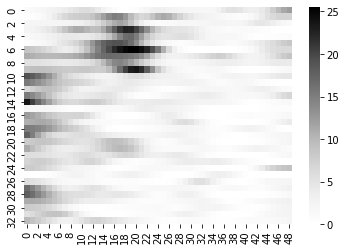

In [171]:
sns.heatmap(fr_map_trial_df_d.loc[1,0].dropna(axis=1).loc[76].T,cmap='Greys')

In [151]:
pa.concat_fr_map_trial_df_d(fr_map_trial[0],spk_beh_df)

AttributeError: 'dict' object has no attribute 'groupby'

In [150]:
fr_map_trial[0][1]

(318, 100, 11)

In [22]:
dpp.corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(beh_df,n_lin=200,speed_key='speed_oef',speed_thresh=10.)




# whether different smoothing hyperparam matters

In [92]:
from sklearn.metrics import confusion_matrix
def get_states_count_overlap(v_l,bins=(0,1,5,np.inf)):
    state_l = []
    c_l = {}
    for v in v_l:
        state=pd.cut(v,bins,labels=False,retbins=False,include_lowest=True)
        state_l.append(state)

    for i in range(len(v_l)-1):
        for j in range(i+1,len(v_l)):
            c = confusion_matrix(state_l[i],state_l[j])
            c_l[(i,j)] = c
     
    return c_l
        

In [84]:
v_l = [sp_oef,sp_raw]
c_l = get_states_count_overlap(v_l)


> /tmp/ipykernel_801379/1973668155.py(9)get_states_count_overlap()
      7         state_l.append(state)
      8     pdb.set_trace()
----> 9     for i in range(len(v_l)-1):
     10         for j in range(i+1,len(v_l)):
     11             c = confusion_matrix(state_l[i],state_l[j])

ipdb> c


In [85]:
c_l

{(0,
  1): array([[215, 524, 274],
        [ 31, 239, 167],
        [  6,  60, 484]])}

In [100]:
beh_df.reset_index()['v'].

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
119559   -1.948428
119560   -1.784407
119561   -1.529552
119562   -1.181782
119563   -0.772733
Name: v, Length: 119564, dtype: float64

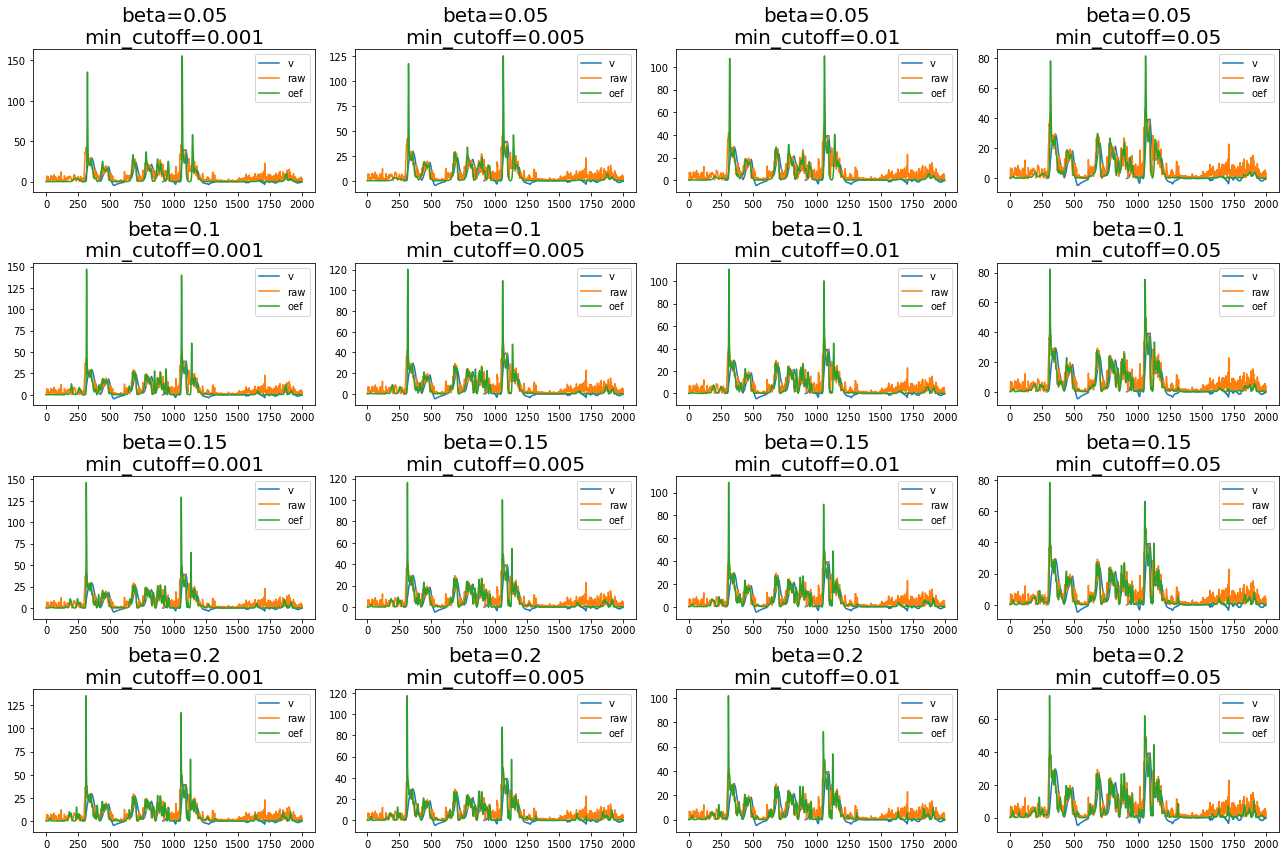

In [101]:
ntime = 2000
xy=np.stack([behavior.position.x,behavior.position.y],axis=1)[:ntime]
timestamps = behavior.timestamps[:ntime]
dt=0.033

vx_raw = np.gradient(xy[:ntime,0]) / dt
vy_raw = np.gradient(xy[:ntime,1]) / dt
sp_raw = np.sqrt(vx_raw**2 + vy_raw**2)
ma = np.abs(vx_raw) <= 2

v_old = beh_df['v'].iloc[:ntime].values

d_cutoff = 1.
res_d = {}

sp_l = {}
sp_l['raw'] = sp_raw
# sp_l['kalman'] = v_old

beta_l = [0.05,0.1,0.15,0.2]
min_cutoff_l = [0.001,0.005,0.01,0.05]

fig,axs=plt.subplots(len(beta_l),len(min_cutoff_l),figsize=(3*6,3*4))

for ii,beta in enumerate(beta_l):
    res_res_d={}
    for jj,min_cutoff in enumerate(min_cutoff_l):
        xy_smth, v_oef = oef.get_speed_one_euro_filter(xy,timestamps,min_cutoff=min_cutoff,beta=beta,d_cutoff=d_cutoff)
        sp_oef = np.sqrt(v_oef[:,0]**2+v_oef[:,1]**2)
        dev = np.linalg.norm(vx_raw[ma] - v_oef[ma,0])
        res_res_d[min_cutoff] = dev
        
        ax=axs[ii,jj]
        ax.plot(v_old,label='v')
        ax.plot(sp_raw,label='raw')
        ax.plot(sp_oef,label='oef')
        ax.set_title(f'beta={beta}\nmin_cutoff={min_cutoff}')
        ax.legend()
        
        sp_l[(beta,min_cutoff)]=sp_oef
        
    res_d[beta] = res_res_d
plt.tight_layout()
    
res_d = pd.DataFrame(res_d)
        

In [102]:
c_l = get_states_count_overlap(list(sp_l.values()))

In [122]:
keys = np.array(list(sp_l.keys()))

/tmp/ipykernel_801379/2129166521.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  keys = np.array(list(sp_l.keys()))


In [114]:
c_l = pd.concat({k:pd.DataFrame(c) for k,c in c_l.items()},axis=0)

[Text(0, 0, '(0.05, 0.001)'),
 Text(1, 0, '(0.05, 0.005)'),
 Text(2, 0, '(0.05, 0.01)'),
 Text(3, 0, '(0.05, 0.05)'),
 Text(4, 0, '(0.1, 0.001)'),
 Text(5, 0, '(0.1, 0.005)'),
 Text(6, 0, '(0.1, 0.01)'),
 Text(7, 0, '(0.1, 0.05)'),
 Text(8, 0, '(0.15, 0.001)'),
 Text(9, 0, '(0.15, 0.005)'),
 Text(10, 0, '(0.15, 0.01)'),
 Text(11, 0, '(0.15, 0.05)'),
 Text(12, 0, '(0.2, 0.001)'),
 Text(13, 0, '(0.2, 0.005)'),
 Text(14, 0, '(0.2, 0.01)'),
 Text(15, 0, '(0.2, 0.05)')]

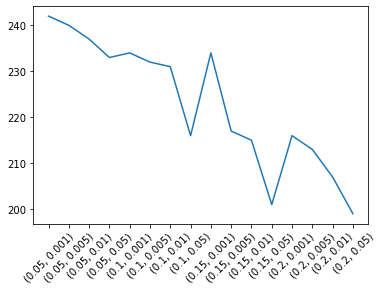

In [125]:
ax=c_l.loc[0].loc[(slice(None),0),0].plot()
xticklabels=keys[c_l.loc[0].index.get_level_values(0).unique()]
ax.set_xticks(np.arange(len(xticklabels)))
ax.set_xticklabels(xticklabels,rotation=45)

In [123]:
keys[c_l.loc[0].index.get_level_values(0).unique()]

array([(0.05, 0.001), (0.05, 0.005), (0.05, 0.01), (0.05, 0.05),
       (0.1, 0.001), (0.1, 0.005), (0.1, 0.01), (0.1, 0.05),
       (0.15, 0.001), (0.15, 0.005), (0.15, 0.01), (0.15, 0.05),
       (0.2, 0.001), (0.2, 0.005), (0.2, 0.01), (0.2, 0.05)], dtype=object)

In [49]:
oef.get_speed_one_euro_filter

<function one_euro_filter.get_speed_one_euro_filter(xy, timestamps, min_cutoff=0.05, beta=0.2, d_cutoff=1.0)>

In [50]:
res_d

,0.2,0.3,0.4
0.0001,58.284169,74.070073,65.998976


<AxesSubplot:>

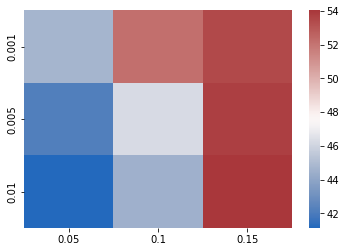

In [53]:
%matplotlib inline
sns.heatmap(res_d,cmap='vlag')

In [30]:
import one_euro_filter as oef


In [64]:
reload(dpp)
beh_df = dpp.get_multi_maze_behavior_df(behavior,min_cutoff=0.05,beta=0.2,d_cutoff=1.)
beh_df_sub = beh_df.query('task_index==0')

/mnt/home/szheng/projects/util_code/data_prep_pyn.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[val.index,info_key] = info_val_l_new[int(k[0])][int(k[1])]
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df.loc[val.index,'segment'] = seg_l
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:598: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [66]:
reload(dpp)
beh_df_sub=dpp.get_v_kalman_and_aligned(beh_df_sub)

<AxesSubplot:xlabel='Time (s)'>

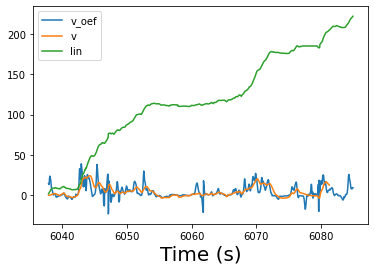

In [15]:
beh_df.query('task_index==0&trial==7')[['v_oef','v','lin']].plot()

<IPython.core.display.Javascript object>


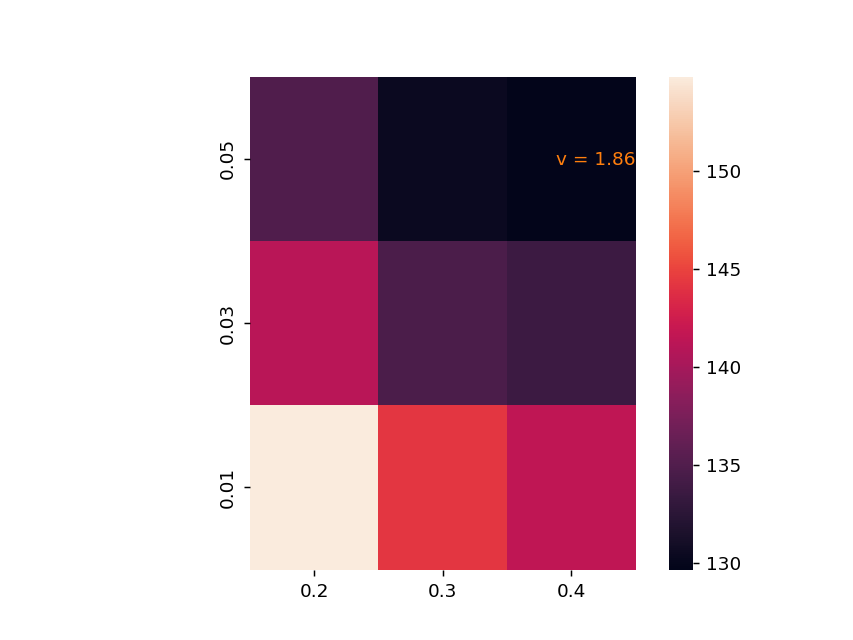

In [16]:
%matplotlib notebook

import animate_helper as ah
reload(ah)
tr=0
one_chunk = beh_df.query('trial==@tr')
data = one_chunk[['x','y']].values.T
x_all = beh_df['x'].values
y_all = beh_df['y'].values
speed_l = one_chunk['v_oef'].values
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
DO_SAVE=False

save_fn = f'behavior_trial{tr}.mp4'

fig,ax,ani=ah.animate_movement_in_maze(data,x_all,y_all,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':30},dosave=DO_SAVE,
                                    do_plot_background_maze=True,
                                    n_tail=100,trial_l=None,speed_l=speed_l,
                                    save_dir=save_dir,save_fn=save_fn
                                )

In [ ]:
%matplotlib notebook

import animate_helper as ah
reload(ah)
tr=67
one_chunk = beh_df.query('v_oef<0')
data = one_chunk[['x','y']].values.T
x_all = beh_df['x'].values
y_all = beh_df['y'].values
speed_l = one_chunk['v_oef'].values
trial_l = one_chunk['trial'].fillna(0).values
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
DO_SAVE=False

save_fn = f'behavior_trial{tr}.mp4'

fig,ax,ani=ah.animate_movement_in_maze(data,x_all,y_all,hist2d_kws={},ax_kws={},fig=None,ax=None,
                                    animate_kws={'interval':5},dosave=DO_SAVE,
                                    do_plot_background_maze=True,
                                    n_tail=100,trial_l=trial_l,speed_l=speed_l,
                                    save_dir=save_dir,save_fn=save_fn
                                )

# ratemaps!

In [63]:
fr_map_task_dict = pa.get_fr_map_trial_multi_task(spk_beh_df,cell_cols_d['pyr'],trialtype_key_dict = {'alternation':'visitedArm','linearMaze':'direction'}, \
                        speed_key='v_oef',speed_thresh=1.)

KeyError: 'v_oef'

In [ ]:
get_fr_map_trial(df,cell_columns,trialtype_key='visitedArm',**kwargs)